In [109]:
from main import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import timedelta, datetime

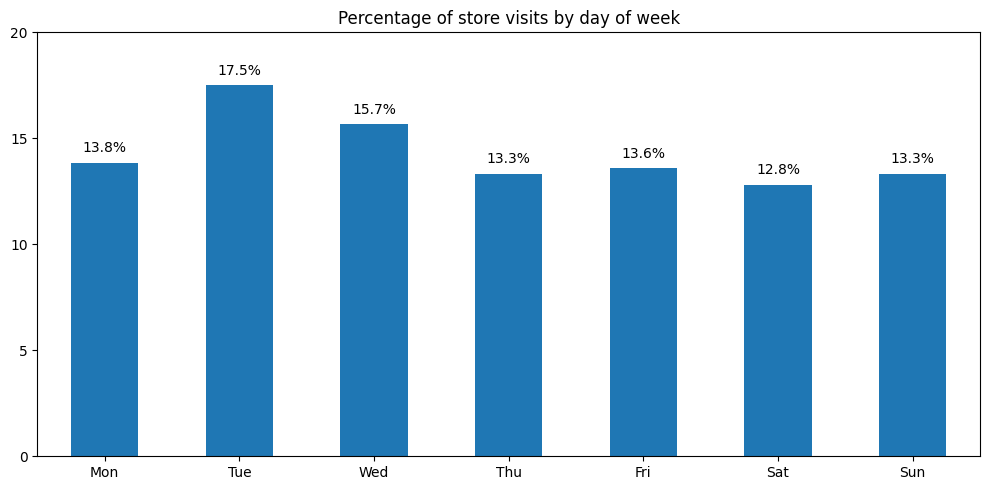

In [98]:
df = pd.read_csv('data/receipts.csv', parse_dates=['datetime'])

plt.figure(figsize=(10, 5))
day_percentages = df.groupby(df['datetime'].dt.dayofweek).size() / len(df) * 100
ax = day_percentages.plot(kind='bar', title="Percentage of store visits by day of week")
plt.ylim(0, 20)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.yticks(range(0, 25, 5))
plt.xlabel("")

for i, v in enumerate(day_percentages):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.savefig('data/graphs/day_percentages.png', dpi=300)
plt.show()

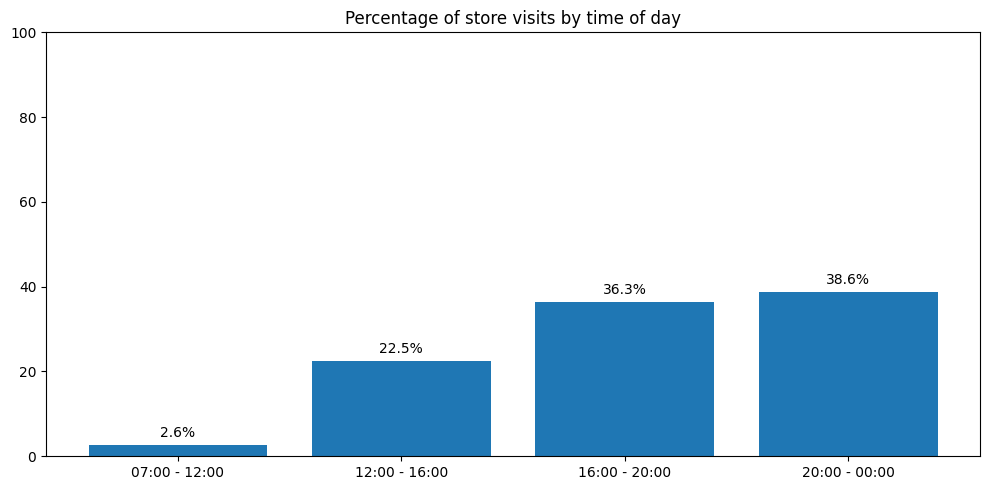

In [99]:
df = pd.read_csv('data/receipts.csv', parse_dates=['datetime'])

times_of_day = {
    "07:00 - 12:00":[7,  12],
    "12:00 - 16:00":[12, 16], 
    "16:00 - 20:00":[16, 20],
    "20:00 - 00:00":[20, 24],
}

def map_tod(hr):
    for label, (start, end) in times_of_day.items():
        if start <= hr < end:
            return label
    return "other"

receipts_tod = df['datetime'].dt.hour.apply(map_tod)

tod_counts = receipts_tod.value_counts().reindex(times_of_day.keys())
tod_percentages    = tod_counts / tod_counts.sum() * 100

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(tod_percentages.index, tod_percentages.values)
ax.set_ylim(0, 100)
ax.set_title("Percentage of store visits by time of day")
plt.xticks(range(4), ['07:00 - 12:00', '12:00 - 16:00', '16:00 - 20:00', '20:00 - 00:00'], rotation=0)

for i, v in enumerate(tod_percentages):
    ax.text(i, v + 2, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.savefig('data/graphs/time_of_day_percentages.png', dpi=300)
plt.show()

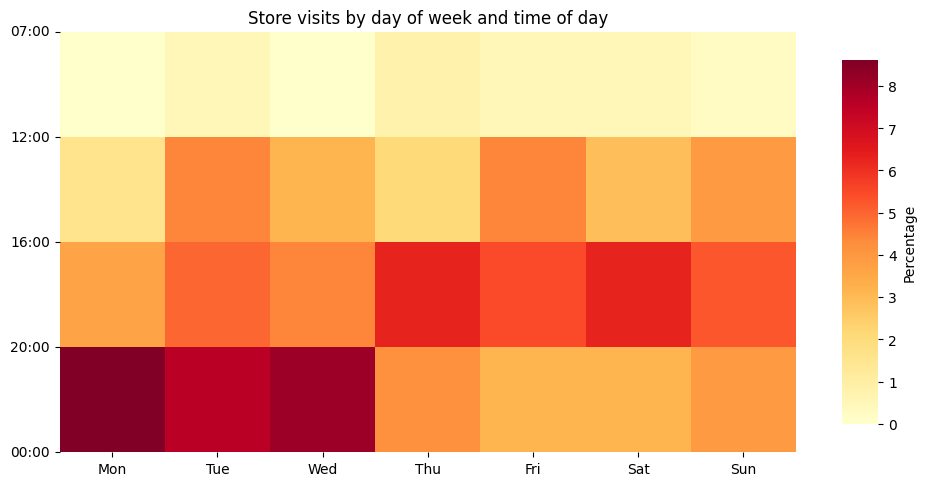

In [100]:
df = pd.read_csv('data/receipts.csv', parse_dates=['datetime'])

df['day']         = df['datetime'].dt.strftime('%a')
df['time_of_day'] = df['datetime'].dt.hour.apply(map_tod)

pivot = df.pivot_table(
    index='time_of_day',
    columns='day',
    values='receipt_id',
    aggfunc='count',
    fill_value=0
)

days_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
times_order = ['07:00 - 12:00', '12:00 - 16:00', '16:00 - 20:00', '20:00 - 00:00']

pivot = pivot[days_order]
pivot = pivot.reindex(times_order)

pivot_pct = pivot / pivot.values.sum() * 100

plt.figure(figsize=(10,5))
ax = sns.heatmap(
    pivot_pct,
    cmap='YlOrRd',
    square=True,
    cbar_kws={
        'label':'Percentage',
        'shrink':0.8,
        'aspect':10
        }
)

edges = [t.split(' - ')[0] for t in times_order]
edges.append(times_order[-1].split(' - ')[1])

n = len(times_order)
ax.set_yticks(np.arange(n+1))
ax.set_yticklabels(edges, rotation=0)

ax.set_xticks(np.arange(len(days_order)) + 0.5)
ax.set_xticklabels(days_order, rotation=0)

plt.title('Store visits by day of week and time of day')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig('data/graphs/day_time_heatmap.png', dpi=300)
plt.show()

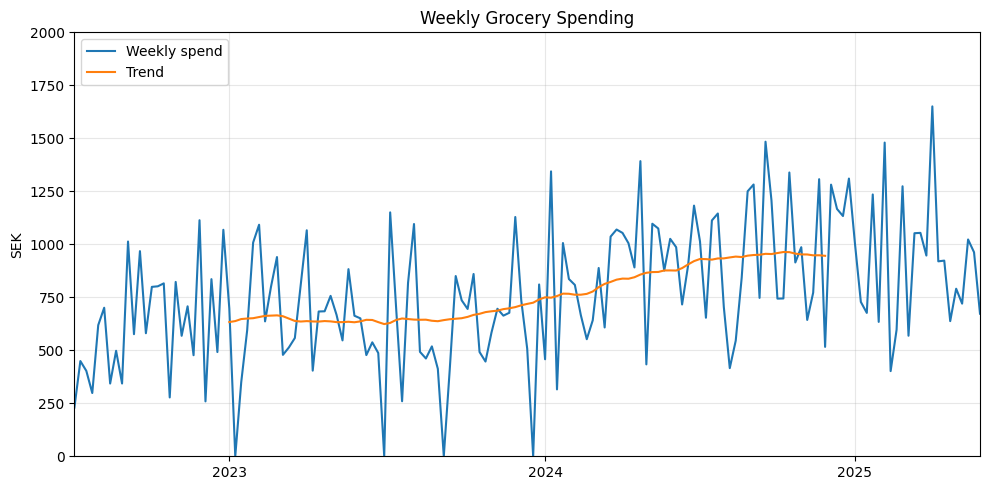

In [101]:
df = pd.read_csv('data/receipts.csv', parse_dates=['datetime'])

fig, ax = plt.subplots(figsize=(10, 5))
weekly_spend = df.set_index('datetime')['total_amount'].resample('W').sum().plot(ax=ax, title="Weekly Grocery Spending", label='Weekly spend')
weekly_result = seasonal_decompose(df.set_index('datetime')['total_amount'].resample('W').sum(), model='additive', period=52)
weekly_result.trend.plot(ax=ax, label='Trend')

ax.set_ylim(bottom=0, top=2000)
ax.set_xlabel("")
ax.set_ylabel("SEK")
ax.legend(loc='upper left')

years = pd.date_range(start=df.datetime.min(), end=df.datetime.max(), freq='YS')
ax.set_xticks(years)
ax.set_xticklabels([d.strftime('%Y') for d in years])
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('data/graphs/weekly_spend.png', dpi=300)
plt.show()

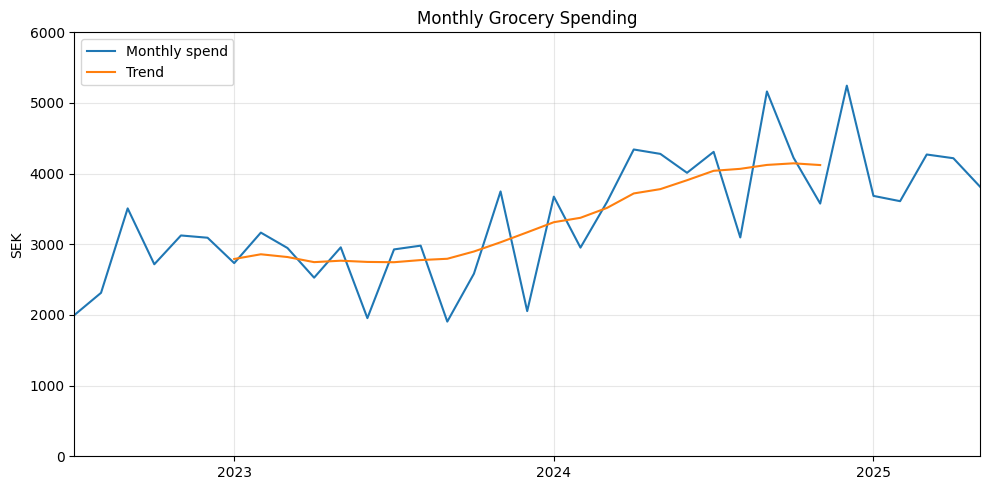

In [102]:
df = pd.read_csv('data/receipts.csv', parse_dates=['datetime'])

fig, ax = plt.subplots(figsize=(10, 5))
monthly_spend = df.set_index('datetime')['total_amount'].resample('ME').sum().plot(ax=ax, title="Monthly Grocery Spend", label='Monthly spend')
ax.set_ylim(bottom=0, top=6000)
ax.set_xlabel("")
ax.set_ylabel("SEK")

monthly = df.set_index('datetime')['total_amount'].resample('ME').sum()
monthly_result = seasonal_decompose(monthly, model='additive', period=12)

monthly_result.trend.plot(ax=ax, title="Monthly Grocery Spending", label='Trend')
ax.set_ylim(bottom=0, top=6000)
ax.set_xlabel("")
ax.legend(loc='upper left')

years = pd.date_range(start=df.datetime.min(), end=df.datetime.max(), freq='YS')
ax.set_xticks(years)
ax.set_xticklabels([d.strftime('%Y') for d in years])
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('data/graphs/monthly_spend.png', dpi=300)
plt.show()

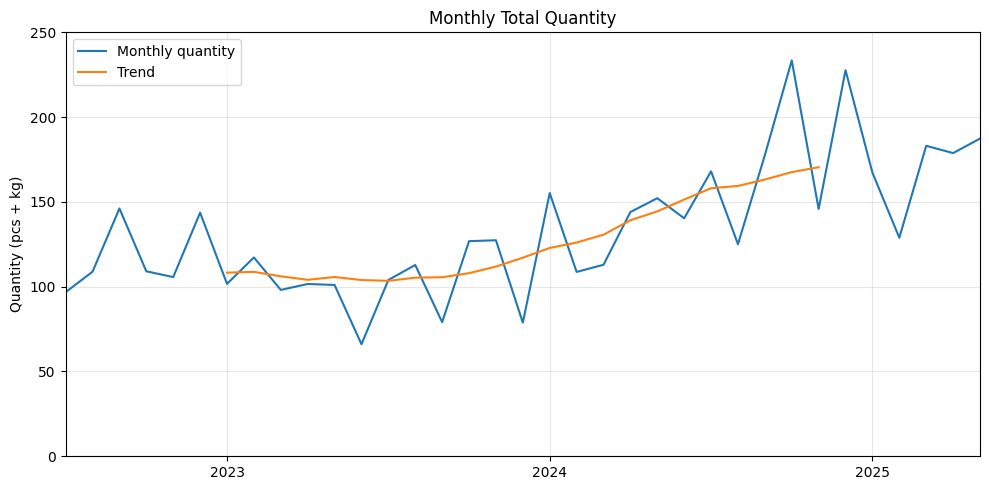

In [103]:
receipts_df = pd.read_csv('data/receipts.csv', parse_dates=['datetime'])
scanned_items_df = pd.read_csv('data/scanned_items.csv')

fig, ax = plt.subplots(figsize=(10, 5))

df = (
    scanned_items_df
      .merge(
         receipts_df[['receipt_id','datetime']],
         on='receipt_id', how='left'
      )
)

df['month'] = df['datetime'].dt.to_period('M').dt.to_timestamp()

monthly_qty = df.groupby('month')['quantity'].sum()

monthly_qty.plot(ax=ax, label='Monthly quantity')
monthly_result = seasonal_decompose(monthly_qty, model='additive', period=12)
monthly_result.trend.plot(ax=ax, label='Trend')

ax.set_ylabel('Quantity (pcs + kg)')
ax.set_title('Monthly Total Quantity')
ax.tick_params(axis='x', rotation=0)
ax.grid(alpha=0.3)
ax.legend(loc='upper left')

years = pd.date_range(start=df.datetime.min(), end=df.datetime.max(), freq='YS')
ax.set_xticks(years)
ax.set_xticklabels([d.strftime('%Y') for d in years])
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.set_xlabel('')
ax.set_ylim(0, 250)

plt.tight_layout()
plt.savefig('data/graphs/monthly_quantity.png', dpi=300)
plt.show()

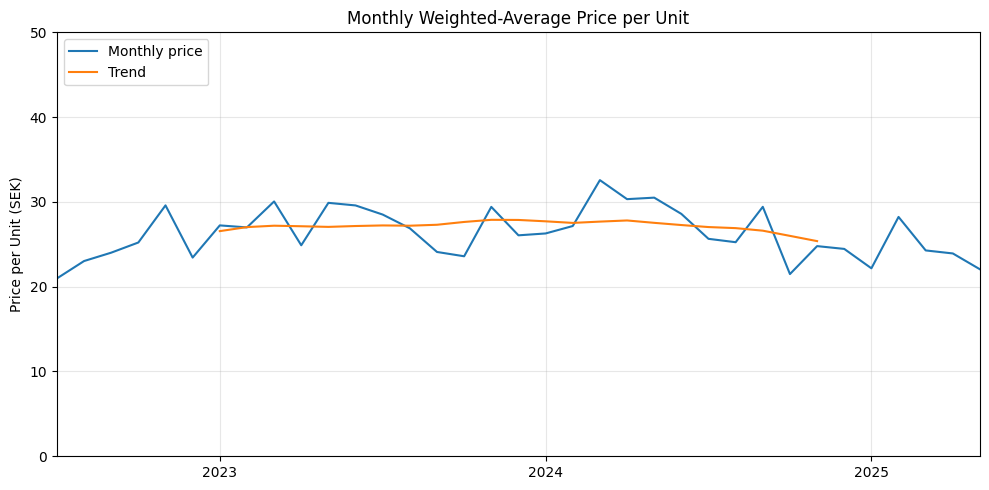

In [104]:
receipts_df = pd.read_csv('data/receipts.csv', parse_dates=['datetime'])
scanned_items_df = pd.read_csv('data/scanned_items.csv')

fig, ax = plt.subplots(figsize=(10, 5))

df = (
    scanned_items_df
      .merge(
         receipts_df[['receipt_id','datetime']],
         on='receipt_id', how='left'
      )
)

df['month'] = df['datetime'].dt.to_period('M').dt.to_timestamp()

monthly_spend = df.groupby('month')['total_price'].sum()
monthly_qty = df.groupby('month')['quantity'].sum()
wavg_price = monthly_spend / monthly_qty

wavg_price.plot(ax=ax, label='Monthly price')
price_result = seasonal_decompose(wavg_price, model='additive', period=12)
price_result.trend.plot(ax=ax, label='Trend')

ax.set_ylabel('Price per Unit (SEK)')
ax.set_title('Monthly Weighted-Average Price per Unit')
ax.tick_params(axis='x', rotation=0)
ax.grid(alpha=0.3)
ax.legend(loc='upper left')

years = pd.date_range(start=df.datetime.min(), end=df.datetime.max(), freq='YS')
ax.set_xticks(years)
ax.set_xticklabels([d.strftime('%Y') for d in years])
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.set_xlabel('')
ax.set_ylim(0, 50)

plt.tight_layout()
plt.savefig('data/graphs/monthly_weighted_average_price.png', dpi=300)
plt.show()

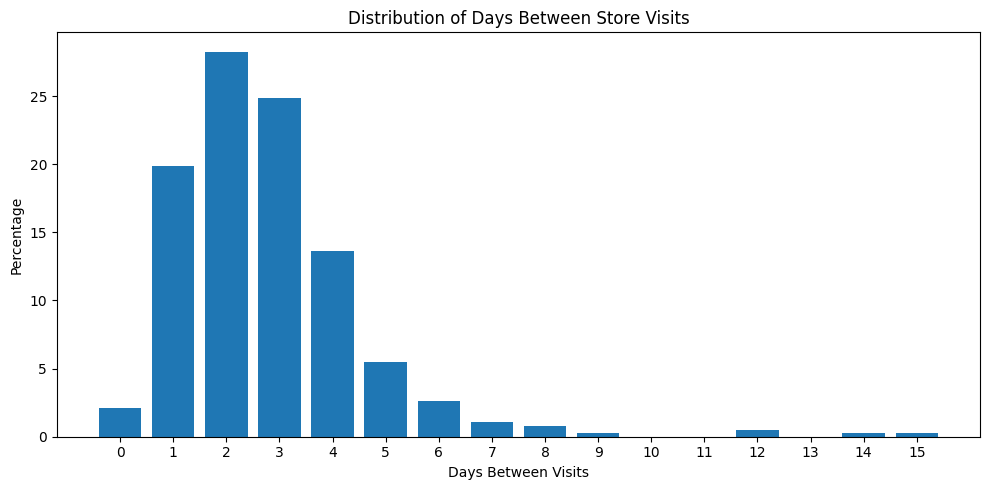

In [105]:
df = pd.read_csv('data/receipts.csv', parse_dates=['datetime'])

receipts_df = df.sort_values('datetime')
receipts_df['date_only'] = receipts_df['datetime'].dt.normalize()  
receipts_df['days_between'] = receipts_df['date_only'].diff().dt.days

gap_counts = (
    receipts_df['days_between']
    .dropna()
    .astype(int)
    .value_counts()
    .sort_index()
)

gap_pcts = (gap_counts / gap_counts.sum()) * 100

fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(gap_pcts.index, gap_pcts.values)
ax.set_xlabel('Days Between Visits')
ax.set_ylabel('Percentage')
ax.set_title('Distribution of Days Between Store Visits')

max_days = gap_pcts.index.max()
ax.set_xticks(range(max_days + 1))
ax.tick_params(axis='x')

plt.tight_layout()
plt.savefig('data/graphs/visit_gap_distribution.png', dpi=300)
plt.show()

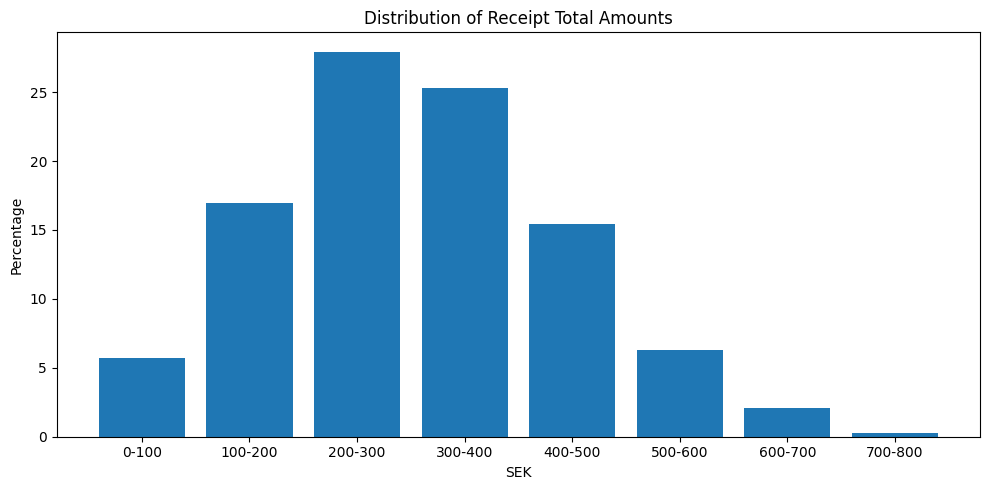

In [106]:
df = pd.read_csv('data/receipts.csv', parse_dates=['datetime'])

receipts_df["amount_bracket"] = pd.cut(receipts_df["total_amount"], range(0, 900, 100), labels=[f"{i}-{i+100}" for i in range(0, 800, 100)])

bracket_counts = receipts_df["amount_bracket"].value_counts().sort_index()
bracket_pcts = (bracket_counts / bracket_counts.sum()) * 100

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(bracket_pcts.index, bracket_pcts.values)
ax.set_xlabel('SEK')
ax.set_ylabel('Percentage')
ax.set_title('Distribution of Receipt Total Amounts')

plt.tight_layout()
plt.savefig('data/graphs/amount_bracket_distribution.png', dpi=300)
plt.show()

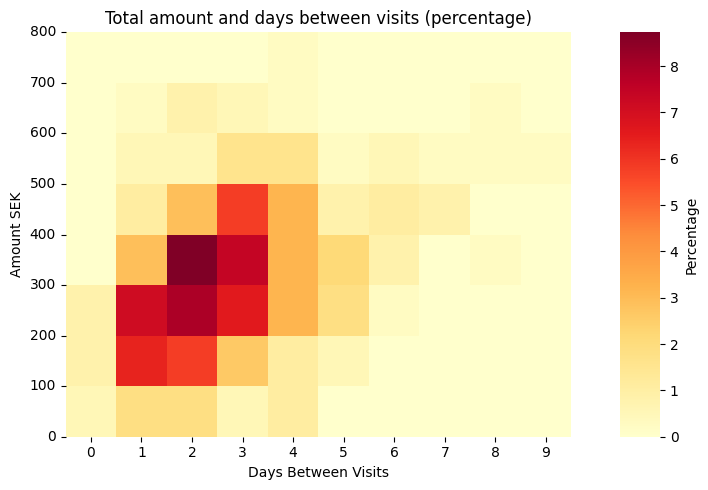

In [107]:
df = pd.read_csv('data/receipts.csv', parse_dates=['datetime'])

df["amount_bracket"] = pd.cut(
    df["total_amount"],
    bins=range(0, 900, 100),
    labels=[f"{i}-{i+100}" for i in range(0, 800, 100)],
    right=False
)

df = df.sort_values("datetime")
df["date_only"]    = pd.to_datetime(df["datetime"]).dt.normalize()
df["days_between"] = df["date_only"].diff().dt.days

pivot = df.pivot_table(
    index="days_between",
    columns="amount_bracket", 
    values="receipt_id",
    aggfunc="count",
    observed=False
)

days_order = list(range(10))
brackets_order = [f"{i}-{i+100}" for i in range(0, 800, 100)]
pivot = pivot.reindex(index=days_order, fill_value=0)[brackets_order]

total_receipts = pivot.sum().sum()
pivot_pct = (pivot / total_receipts) * 100

heatmap_data = pivot_pct.T.iloc[::-1]

plt.figure(figsize=(10,5))
ax = sns.heatmap(
    heatmap_data,
    cmap="YlOrRd",
    cbar_kws={
        'label':'Percentage',
        'aspect':10
        },
    square=True,
    fmt=".1f"
)

bounds = [int(b.split('-')[0]) for b in brackets_order]
bounds.append(int(brackets_order[-1].split('-')[1]))

edge_labels = bounds[::-1]

ax.set_xticks(np.arange(len(days_order)) + 0.5)
ax.set_xticklabels(days_order, rotation=0)
ax.set_yticks(np.arange(len(edge_labels)))
ax.set_yticklabels(edge_labels, rotation=0)

plt.xlabel("Days Between Visits")
plt.ylabel("Amount SEK")
plt.title("Total amount and days between visits (percentage)")
plt.tight_layout()
plt.savefig('data/graphs/amount_days_between_heatmap.png', dpi=300)
plt.show()

{'Dairy': 27253.75, 'Fish': 2056.49, 'Meat': 32073.65, 'Other': 48031.549999999996, 'Produce': 8834.7}


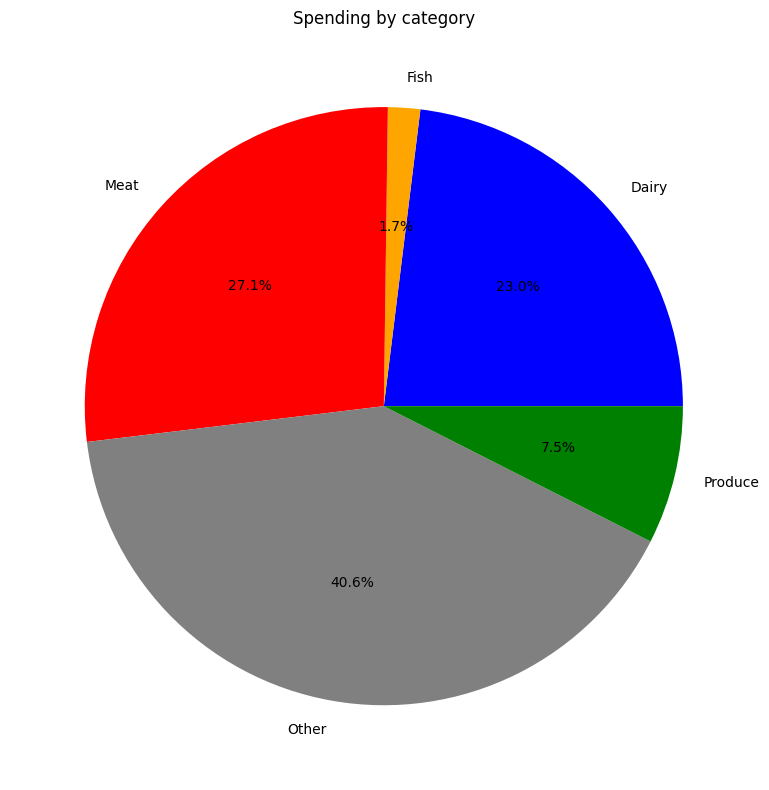

In [108]:
scanned_items_df = pd.read_csv('data/scanned_items.csv')
categorized_articles_df = pd.read_csv('data/categorized_articles.csv')

df = (
    scanned_items_df.merge(categorized_articles_df[['article_number','category']], on='article_number', how='left')
)
df['category'] = df['category'].fillna('Other')

spending_by_category = (
    df
     .groupby('category')['total_price']
     .sum()
     .to_dict()
)

print(spending_by_category)

colors = {
    'Dairy': 'blue',
    'Meat': 'red',
    'Fish': 'orange',
    'Produce': 'green',
    'Other': 'gray'
}

fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(spending_by_category.values(), labels=spending_by_category.keys(), autopct='%1.1f%%', colors=[colors[k] for k in spending_by_category.keys()])
plt.title("Spending by category")
plt.tight_layout()
plt.savefig('data/graphs/spending_by_category.png', dpi=300)
plt.show()